In [40]:
# Import libraries
from collections import defaultdict
import numpy as np
from sklearn.metrics import mean_squared_error
import sys
import time
import matplotlib.pyplot as plt
import random

In [41]:
# Some dataset info
n_users = 943
n_items = 1682

### Read Training Data

In [42]:
# Merge ua.base and ub.base to get a single matrix-based training set 'r_train'
r_train = np.zeros((n_users, n_items))

f = open('/ua.base')
for l in f:
    row = l.split()
    r_train[int(row[0])-1][int(row[1])-1] = float(row[2])
f.close()

f = open('/ub.base')
for l in f:
    row = l.split()
    r_train[int(row[0])-1][int(row[1])-1] = float(row[2])
f.close()

### Read Testing Data

In [43]:
# Merge ua.test and ub.test to get a single testing set 'r_test'
r_test = defaultdict(list)

f = open('/ua.test')
for l in f:
    row = l.split()
    r_test[row[0]].append((row[1], float(row[2])))
f.close()

f = open('/ub.test')
for l in f:
    row = l.split()
    r_test[row[0]].append((row[1], float(row[2])))
f.close()

### Read Item Info

In [44]:
# Read item info and store in a dict
item_info = defaultdict(list)
f = open('Data/u.item')

for l in f:
    row = l.split('|')
    item_info[row[0]].append((row[0], row[1], row[2]))

f.close()

### Matrix factorization to obtain user and item matrix such that error is minimized

In [54]:
# Function to generate user and item latent feature matrix (using gradient descent)
def matrix_fact(p,q,lf):
    # Some initializations
    # Learning Rate
    alpha = 0.001
    # Regularization coefficient
    l = 0.01
    # User bias
    u_bias = np.zeros(n_users)
    # Item bias
    i_bias = np.zeros(n_items)
    # Global bias
    g_bias = np.mean(r_train[np.where(r_train != 0)])
    # Number of steps
    steps = 40

    # Tranpose matrix q
    q = q.T

    # MSE and step list
    MSE_list = []
    step_list = []
    
    for s in range(steps):
        # Start time
        start = time.time()

        # Update values in p and q using gradient descent
        for i in range(n_users):
            for j in range(n_items):
                if r_train[i][j] > 0:
                    # Calculate error
                    try:
                        r_pred = (np.dot(p[i,:],q[:,j]) + u_bias[i] + i_bias[j] + g_bias)
                        error = r_train[i][j] - r_pred
                    except (IndexError):
                            print(i , j)
                            sys.exit(1)

                    # Calculate gradient and modify the values of p and q
                    try:
                        p[i,:] += 2 * alpha * (error * q[:,j] - l * p[i,:])
                        q[:,j] += 2 * alpha * (error * p[i,:] - l * q[:,j])
                    except (IndexError):
                        print(i , j , l)
                        sys.exit(1)
                    
                    # Update values of the biases
                    u_bias[i] += alpha * (error - l * u_bias[i])
                    i_bias[j] += alpha * (error - l * i_bias[j])

        # Find MSE and stop training if error is below certain threshold
        error_total = 0
        count = 0
        for i in range(n_users):
            for j in range(n_items):
                if r_train[i][j] > 0:
                    try:
                        r_pred = (np.dot(p[i,:],q[:,j]) + u_bias[i] + i_bias[j] + g_bias)
                        error_total += pow(r_train[i][j] - r_pred,2)
                        count += 1
                    except (IndexError):
                        print(i , j)
                        sys.exit(1)

        # Store MSE and step count
        MSE_list.append(error_total/count)
        step_list.append(s+1)

        # End time
        end = time.time()

        # Total time to complete this epoch
        total_time = end - start

        # Print time taken to complete this epoch
        print("Step {} - COMPLETE  |  Time = {} seconds".format(s+1, total_time))

        # If new MSE - old MSE < 0.000001 stop training
        if len(MSE_list) >= 2 and MSE_list[-2] - MSE_list[-1] <= 0.000001:
            break
    
    # Plot learning curve
    plt.plot(step_list, MSE_list)
    plt.xlabel('Iterations (Steps)')
    plt.ylabel('MSE')
    plt.title('Learning Curve for lf = {}'.format(lf))
    plt.show()

    # Print final training MSE
    print("Final training MSE = {}".format(MSE_list[-1]))

    q = q.T

    # return the biases and latent factors
    return u_bias, i_bias, g_bias, p, q

### Testing function

In [55]:
# Test the matrix based model on the test set
def test_ratings(ratings_pred):
    # Actual ratings matrix
    r_test_actual = []
    # Predicted ratings matrix
    r_test_pred = []
    
    # Create rating and rating_pred matrix
    for u,l in r_test.items():
        for i in l:
            r_test_actual.append(i[1])
            r_test_pred.append(ratings_pred[int(u)-1][int(i[0])-1])
    
    # MSE
    print("Test MSE = {}".format(mean_squared_error(r_test_actual, r_test_pred)))

### Calling matrix factorization function for different values of latent features (lf)



Number of latent features lf = 10
Step 1 - COMPLETE  |  Time = 3.584303855895996 seconds
Step 2 - COMPLETE  |  Time = 3.458815336227417 seconds
Step 3 - COMPLETE  |  Time = 3.375845432281494 seconds
Step 4 - COMPLETE  |  Time = 3.280216932296753 seconds
Step 5 - COMPLETE  |  Time = 3.199023962020874 seconds
Step 6 - COMPLETE  |  Time = 3.189173936843872 seconds
Step 7 - COMPLETE  |  Time = 3.3055472373962402 seconds
Step 8 - COMPLETE  |  Time = 3.1383676528930664 seconds
Step 9 - COMPLETE  |  Time = 3.2164053916931152 seconds
Step 10 - COMPLETE  |  Time = 3.158534526824951 seconds
Step 11 - COMPLETE  |  Time = 3.5484089851379395 seconds
Step 12 - COMPLETE  |  Time = 3.5395619869232178 seconds
Step 13 - COMPLETE  |  Time = 3.500723123550415 seconds
Step 14 - COMPLETE  |  Time = 3.438701868057251 seconds
Step 15 - COMPLETE  |  Time = 3.534075975418091 seconds
Step 16 - COMPLETE  |  Time = 3.820760726928711 seconds
Step 17 - COMPLETE  |  Time = 3.546952486038208 seconds
Step 18 - COMPLE

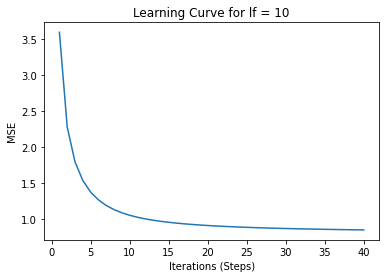

Final training MSE = 0.8494657877490114
Test MSE = 0.9044758287728648


Number of latent features lf = 15
Step 1 - COMPLETE  |  Time = 3.74393367767334 seconds
Step 2 - COMPLETE  |  Time = 3.855449914932251 seconds
Step 3 - COMPLETE  |  Time = 3.70159912109375 seconds
Step 4 - COMPLETE  |  Time = 3.680100202560425 seconds
Step 5 - COMPLETE  |  Time = 3.670916795730591 seconds
Step 6 - COMPLETE  |  Time = 3.5755374431610107 seconds
Step 7 - COMPLETE  |  Time = 3.6217145919799805 seconds
Step 8 - COMPLETE  |  Time = 3.7159130573272705 seconds
Step 9 - COMPLETE  |  Time = 3.7478272914886475 seconds
Step 10 - COMPLETE  |  Time = 3.716961622238159 seconds
Step 11 - COMPLETE  |  Time = 3.61413836479187 seconds
Step 12 - COMPLETE  |  Time = 3.8871920108795166 seconds
Step 13 - COMPLETE  |  Time = 4.591686725616455 seconds
Step 14 - COMPLETE  |  Time = 4.572643756866455 seconds
Step 15 - COMPLETE  |  Time = 4.54145622253418 seconds
Step 16 - COMPLETE  |  Time = 4.562333583831787 seconds
Step 1

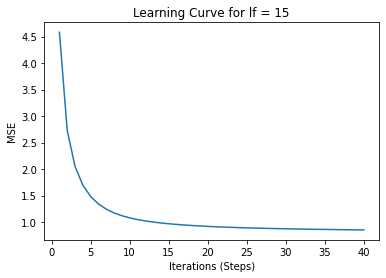

Final training MSE = 0.8535592939991616
Test MSE = 0.9161864957926522


Number of latent features lf = 20
Step 1 - COMPLETE  |  Time = 4.896796464920044 seconds
Step 2 - COMPLETE  |  Time = 4.838863849639893 seconds
Step 3 - COMPLETE  |  Time = 4.6121602058410645 seconds
Step 4 - COMPLETE  |  Time = 4.234188079833984 seconds
Step 5 - COMPLETE  |  Time = 4.571130275726318 seconds
Step 6 - COMPLETE  |  Time = 4.846118927001953 seconds
Step 7 - COMPLETE  |  Time = 6.116293907165527 seconds
Step 8 - COMPLETE  |  Time = 4.013902187347412 seconds
Step 9 - COMPLETE  |  Time = 3.879918098449707 seconds
Step 10 - COMPLETE  |  Time = 4.088715076446533 seconds
Step 11 - COMPLETE  |  Time = 3.9555068016052246 seconds
Step 12 - COMPLETE  |  Time = 3.739799737930298 seconds
Step 13 - COMPLETE  |  Time = 3.851229190826416 seconds
Step 14 - COMPLETE  |  Time = 3.9460361003875732 seconds
Step 15 - COMPLETE  |  Time = 3.8509654998779297 seconds
Step 16 - COMPLETE  |  Time = 3.806863784790039 seconds
Ste

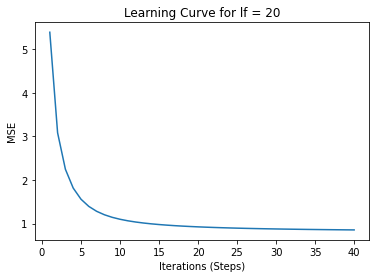

Final training MSE = 0.8551021293059419
Test MSE = 0.9211119958889299


Number of latent features lf = 25
Step 1 - COMPLETE  |  Time = 4.308621644973755 seconds
Step 2 - COMPLETE  |  Time = 4.350365877151489 seconds
Step 3 - COMPLETE  |  Time = 4.902857542037964 seconds
Step 4 - COMPLETE  |  Time = 4.377052307128906 seconds
Step 5 - COMPLETE  |  Time = 4.4660820960998535 seconds
Step 6 - COMPLETE  |  Time = 4.308924913406372 seconds
Step 7 - COMPLETE  |  Time = 4.286016941070557 seconds
Step 8 - COMPLETE  |  Time = 4.388072729110718 seconds
Step 9 - COMPLETE  |  Time = 4.365816593170166 seconds
Step 10 - COMPLETE  |  Time = 4.584104061126709 seconds
Step 11 - COMPLETE  |  Time = 4.565893650054932 seconds
Step 12 - COMPLETE  |  Time = 4.328080415725708 seconds
Step 13 - COMPLETE  |  Time = 4.509804964065552 seconds
Step 14 - COMPLETE  |  Time = 4.387020587921143 seconds
Step 15 - COMPLETE  |  Time = 4.5425519943237305 seconds
Step 16 - COMPLETE  |  Time = 4.711815357208252 seconds
Step 

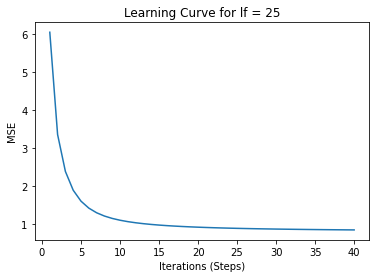

Final training MSE = 0.8553753366507127
Test MSE = 0.9223434331249768


In [60]:
# List of lf values
lf_list = [10, 15, 20, 25]
# Metric list
met_list = []
for lf in lf_list:
    # Create feature matrices p(users) and q(items)
    p = np.ones(shape=(n_users, lf))
    q = np.ones(shape=(n_items, lf))
    
    # Call factorization function
    print("\n\nNumber of latent features lf = {}".format(lf))
    u_bias, i_bias, g_bias, p, q = matrix_fact(p, q, lf)

    # Create the rating matrix from user and item latent feature matrix
    ratings_pred = np.zeros((n_users, n_items))

    for i in range(n_users):
        for j in range(n_items):
            ratings_pred[i][j] += np.dot(p[i,:],q[j,:].T) + u_bias[i] + i_bias[j] + g_bias
            
    # Perform testing (based on ratings)
    test_ratings(ratings_pred)

### Plot Test MSE vs lf values

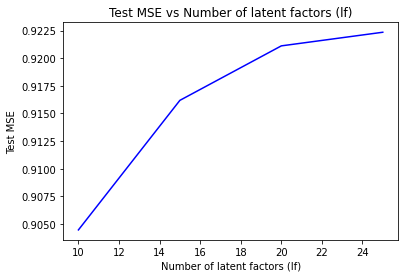

In [61]:
# List of lf values
k_list = [10, 15, 20, 25]
# List of Test MSE values
mse_list = [0.9044758287728648, 0.9161864957926522, 0.9211119958889299, 0.9223434331249768]

# Test MSE vs Number of latent factors (lf)
plt.plot(k_list, mse_list, color="blue")
plt.xlabel("Number of latent factors (lf)")
plt.ylabel("Test MSE")
plt.title("Test MSE vs Number of latent factors (lf)")
plt.show()

### Perform matrix factorization for best value of lf (lf=10)

Step 1 - COMPLETE  |  Time = 3.5014588832855225 seconds
Step 2 - COMPLETE  |  Time = 3.537508726119995 seconds
Step 3 - COMPLETE  |  Time = 3.8045284748077393 seconds
Step 4 - COMPLETE  |  Time = 3.773341178894043 seconds
Step 5 - COMPLETE  |  Time = 3.9782156944274902 seconds
Step 6 - COMPLETE  |  Time = 3.766623020172119 seconds
Step 7 - COMPLETE  |  Time = 3.7166430950164795 seconds
Step 8 - COMPLETE  |  Time = 3.640652894973755 seconds
Step 9 - COMPLETE  |  Time = 3.5990042686462402 seconds
Step 10 - COMPLETE  |  Time = 3.9485487937927246 seconds
Step 11 - COMPLETE  |  Time = 3.9937191009521484 seconds
Step 12 - COMPLETE  |  Time = 3.5970587730407715 seconds
Step 13 - COMPLETE  |  Time = 3.6443448066711426 seconds
Step 14 - COMPLETE  |  Time = 3.6280221939086914 seconds
Step 15 - COMPLETE  |  Time = 3.526463031768799 seconds
Step 16 - COMPLETE  |  Time = 3.720061779022217 seconds
Step 17 - COMPLETE  |  Time = 3.679095506668091 seconds
Step 18 - COMPLETE  |  Time = 3.621087074279785

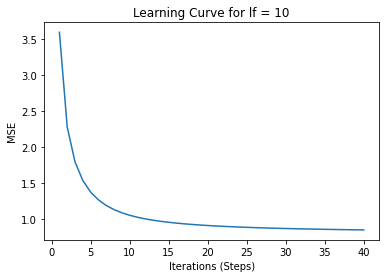

Final training MSE = 0.8494657877490114


In [62]:
# Number of latent features
lf = 10

# Createfeature matrices p(users) and q(items)
p = np.ones(shape=(n_users, lf))
q = np.ones(shape=(n_items, lf))

# Call factorization function
u_bias, i_bias, g_bias, p, q = matrix_fact(p, q, lf=10)

### Ratings prediction matrix

In [42]:
# Create the rating matrix from user and item latent feature matrix
ratings_pred = np.zeros((n_users, n_items))

for i in range(n_users):
    for j in range(n_items):
        ratings_pred[i][j] += np.dot(p[i,:],q[j,:].T) + u_bias[i] + i_bias[j] + g_bias

# Print r_train and ratings_pred for comparison
print("r_train")
print(r_train)

print("\n\n")

print("ratings_pred")
print(ratings_pred)

r_train
[[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]



ratings_pred
[[3.82581432 3.34150408 3.40518852 ... 3.32814387 3.33993882 3.72816346]
 [3.90911763 3.36394202 3.01844665 ... 3.59777816 3.4200105  3.38639585]
 [3.40441466 2.8777635  2.56093605 ... 3.08628326 2.90685149 2.8770296 ]
 ...
 [4.17686807 3.58764265 3.36569166 ... 3.70451516 3.80170643 3.62174701]
 [4.36739806 3.86280879 3.81295132 ... 3.89549992 3.90638172 4.06152054]
 [3.62031846 3.12517504 3.09983718 ... 3.20074092 3.09689873 3.57138401]]


### Precision, Recall and F1 Score @ K (3,5,10)

In [197]:
# Threshold for telling which items are relevant and which are recommended
thresh = 3.5

# K list
k_list = [3,5,10]

# Sample set of users from test set on which precision and recall is calculated
user_set = []
for u,l in r_test.items():
    if len(l) > 9:
        user_set.append(u)
user_set = random.sample(user_set, 5)

# Dictionary to store precision and recall values
pre_rec = defaultdict(list)

# For each k in k_list
for k in k_list:
    # For each user in sampled list
    for u in user_set:
        # Get top-k rated items in test set
        rel_ratings = [p for p in r_test[u]]
        rel_ratings = sorted(rel_ratings, key=lambda x:x[1], reverse=True)
        rel_ratings = rel_ratings[:k]

        # Get top-k unrated items in test set (based on predicted ratings)
        rec_ratings = [(i, ratings_pred[int(u)-1][int(i)-1]) for i,_ in r_test[u]]
        rec_ratings = sorted(rec_ratings, key=lambda x:x[1], reverse=True)
        rec_ratings = rec_ratings[:k]

        # Precision@k = (No of recommended items @k that are relevant) / (No of recommended items @k)
        num = len(set.intersection(set([i for i,r in rel_ratings if r >= thresh]), set([i for i,r in rec_ratings if r >= thresh])))
        den = len([i for i,r in rec_ratings if r >= thresh])
        precision = num/den

        # Recall@k = (No of recommended items @k that are relevant) / (No of of relevant items @k)
        num = len(set.intersection(set([i for i,r in rel_ratings if r >= thresh]), set([i for i,r in rec_ratings if r >= thresh])))
        den = len([i for i,r in rel_ratings if r >= thresh])
        recall = num/den

        # F1 score
        f1 = 0
        if (precision + recall) != 0:
            f1 = (2 * precision * recall)/(precision + recall)

        # Append the precision and recall values
        pre_rec[k].append((u, precision, recall, f1))

# Print the values
for k,v in pre_rec.items():
    print('k = {}'.format(k))
    for u,p,r,f1 in v:
        print("User - {}  |  Precision@k - {}  |  Recall@k - {}  |  F1 score - {}".format(u,p,r,f1))
    print("\n")

k = 3
User - 394  |  Precision@k - 0.3333333333333333  |  Recall@k - 0.3333333333333333  |  F1 score - 0.3333333333333333
User - 145  |  Precision@k - 0.3333333333333333  |  Recall@k - 0.3333333333333333  |  F1 score - 0.3333333333333333
User - 404  |  Precision@k - 0.6666666666666666  |  Recall@k - 0.6666666666666666  |  F1 score - 0.6666666666666666
User - 745  |  Precision@k - 0.3333333333333333  |  Recall@k - 0.3333333333333333  |  F1 score - 0.3333333333333333
User - 274  |  Precision@k - 0.3333333333333333  |  Recall@k - 0.3333333333333333  |  F1 score - 0.3333333333333333


k = 5
User - 394  |  Precision@k - 0.4  |  Recall@k - 0.4  |  F1 score - 0.4000000000000001
User - 145  |  Precision@k - 0.6  |  Recall@k - 0.6  |  F1 score - 0.6
User - 404  |  Precision@k - 0.4  |  Recall@k - 0.4  |  F1 score - 0.4000000000000001
User - 745  |  Precision@k - 0.3333333333333333  |  Recall@k - 0.2  |  F1 score - 0.25
User - 274  |  Precision@k - 0.6  |  Recall@k - 0.6  |  F1 score - 0.6


k =